# Exploation_07

## 1. News_summary

### 1.1 모듈 설정

- summarize를 활용하기 위해 Summa를 설치합니다.

In [37]:
!pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- import할 라이브러리를 보기 편하게 모아놓습니다.

In [38]:
import nltk
nltk.download("book", quiet=True)
from nltk.book import *

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import requests
from summa.summarizer import summarize
from google.colab import drive
import urllib.request
from IPython.display import Image
from wordcloud import WordCloud

### 1.2 함수 정리

#### 1.2.1 preprocess_sentence

- 일단 만들어 놓으면 전처리를 편리하게 할 수 있습니다.

In [ ]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[o]{2,}', 'oo', sentence) # o이 3개 이상이면 2개로 변경. Ex) whoooooo -> whoo
    
    sentence = re.sub(r'[?]{1,}', r' ?? ', sentence)
    sentence = re.sub(r'[" "]+', r' ', sentence)

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 1.2.2 below_threshold_len

- 아래 max_len을 결정하는 과정에서 활용합니다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

#### 1.2.3 above_threshold_len

- 마찬가지로 max_len을 결정하는 과정에서 활용합니다.

In [ ]:
def above_threshold_len(min_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) >= min_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))

#### 1.2.4 decode_sequence

- 훈련된 모델을 테스트하는 용도로 사용합니다.

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (Headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 1.2.5 seq2text, seq2headline

- seq2text는 정수 형태의 시퀀스를 텍스트 형태로 변환합니다(본문)
- seq2headline 위와 동일합니다(헤드라인)

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### 1.3 데이터 로드

- 일단 구글 드라이브를 마운트합니다.

In [39]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


- 오늘 사용할 기사 데이터를 가져옵니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

('news_summary_more.csv', <http.client.HTTPMessage at 0x7fcfc64e25d0>)

- columns로 확인해보니 headlines와 text가 있습니다.

In [ ]:
data.columns

Index(['headlines', 'text'], dtype='object')

- 약 98,400개의 기사 데이터로 보여집니다.

In [ ]:
|data.tail(3)

,headlines,text
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


### 1.4 데이터 전처리

1) 중복 처리

- 중복이 있는지 확인합니다. 

In [ ]:
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())
print('unique한 text 수:', data.text.nunique())

전체 data 길이 : 98401
unique한 headline 수: 98280
unique한 text 수: 98360


- 본문이 중복이라면 정말 중복이 맞을 것 같습니다.  
text를 기준으로 중복 값을 털어냅니다.

In [ ]:
data.drop_duplicates(subset=['text'], inplace = True)
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())

전체 data 길이 : 98360
unique한 headline 수: 98262


In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


2) 텍스트 정규화

- 영어에는 참 많은 축약형이 있습니다. contractions에 묶어서 처리해줍니다.

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- NLTK를 이용하고 있으니 stopwords.words('english')로 영어 불용어 리스트를 불러옵니다.

In [ ]:
stop_words_list = stopwords.words('english')
print('불용어 개수 :', len(stop_words_list))

불용어 개수 : 179
불용어 10개 출력 : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


- NLTK의 stopwords.words에는 불용어가 179개 있습니다.

3) headline, text preprocessing

- 위에서 만든 함수 preprocess_sentence를 text와 headlines에 요긴하게 사용합니다.

- headlines에서 False 값을 주는 이유는 stopwords 처리를 하지 않기 위함입니다.  
clean_headlines.append(preprocess_sentence(s, False))

In [ ]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

- headlines에 sentence preprocessing

In [ ]:
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

- 시간이 생각보다 많이 걸립니다.

- 다시 data에 'Text','Headlines' 컬럼을 만들어 값을 저장합니다.

In [ ]:
data['Text'] = clean_text
data['Headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

- preprocessing 과정에서 혹시 null 값이 발생할 수 있습니다. 찾아봅니다.

In [ ]:
data.isnull().sum()

headlines    0
text         0
Text         0
Headlines    0
dtype: int64

- dropna로 드롭시켜버리려 했는데 Null 값은 없습니다.

In [ ]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


4) 데이터 시각화

- 일단 지금까지 처리한 데이터를 시각화하여 확인합니다.

- word cloud import하여 이용해봤습니다.

(-0.5, 799.5, 599.5, -0.5)

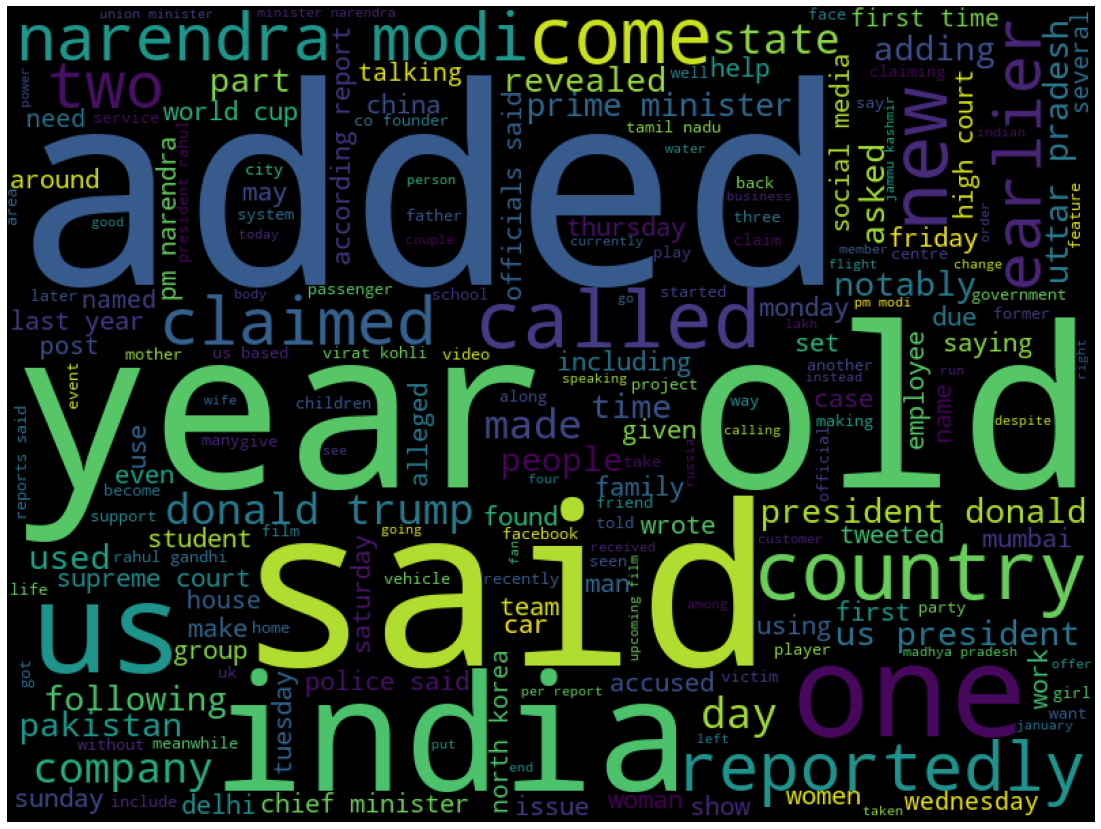

In [45]:
cloud = WordCloud(width=800, height=600).generate(" ".join(data['Text']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

- 본문에서는  added, year, old, said, india 같은 단어들이 많이 사용된걸 확인할 수 있습니다.

(-0.5, 799.5, 599.5, -0.5)

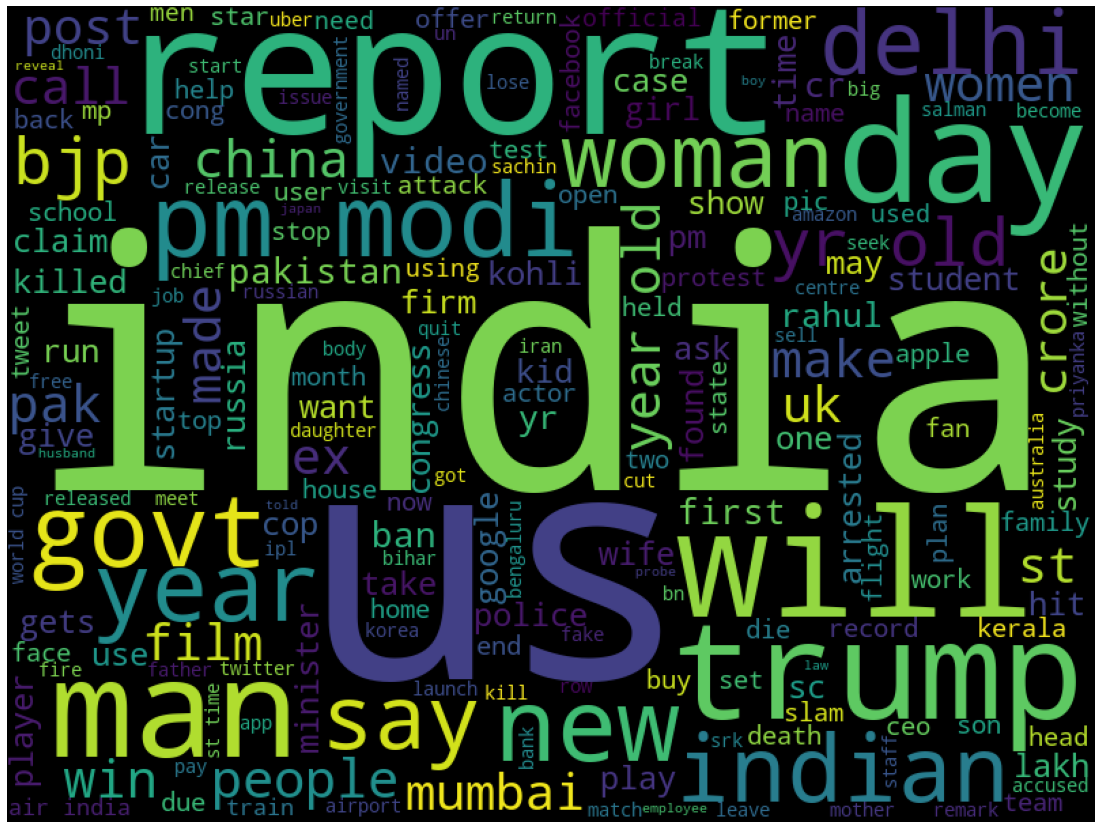

In [46]:
cloud = WordCloud(width=800, height=600).generate(" ".join(data['Headlines']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

- 헤드라인에서는 india, us, report, trump, man, will, day 같은 단어들이 많이 사용된걸 확인할 수 있습니다.

- 단순하게 많이 쓰인 단어만 확인할 수 있지만, 딱딱하지 않은 매우 흥미로운 시각화라고 생각합니다  
(다음은 딱딱한 그래프를 볼 순서입니다.)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


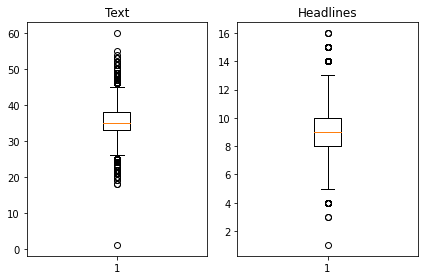

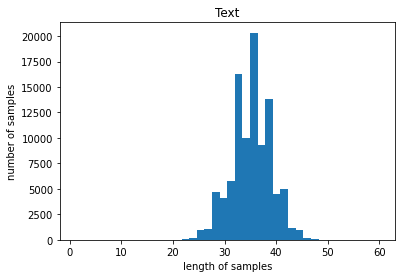

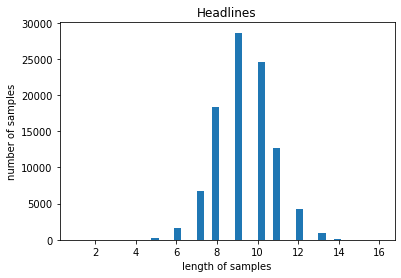

In [ ]:
Text_len = [len(s.split()) for s in data['Text']]
Headline_len = [len(s.split()) for s in data['Headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(Text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(Text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(Text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(Headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(Headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(Headline_len)))

plt.subplot(1, 2, 1)
plt.boxplot(Text_len)
plt.title('Text')
plt.subplot(1, 2, 2)
plt.boxplot(Headline_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(Text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(Headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- Text는 평균 35.099개의 단어로 구성되어있고, Headlines는 9.299개의 단어로 이루어져 있습니다.

- Text에서 60개의 단어로 구성된 데이터를 확인해보겠습니다.

- 최대 길이가 60이므로 60이상을 잡아 확인합니다.

In [ ]:
length_th = [i for i, value in enumerate(Text_len) if value >= 60]

In [ ]:
Headline_len = [len(s.split()) for s in data['Headlines']]

In [ ]:
print(length_th)

[11677]


- 1개 입니다.

In [ ]:
print(data.loc[11677])

headlines    Aapke paas bas ek quality honi chahiye, humili...
text         Congress President Rahul Gandhi on Tuesday sai...
Text         congress president rahul gandhi tuesday said d...
Headlines    aapke paas bas ek quality honi chahiye humilit...
Name: 11677, dtype: object


- 별 문제 없어보입니다.

- 사실 제일 신경쓰이는건 평균보다 한참 아래에서 밑도는 데이터입니다.

In [ ]:
length_tl = [i for i, value in enumerate(Text_len) if value <= 20]

In [ ]:
print(length_tl)

[52, 11713, 12727, 19018, 24685, 29029, 60664, 70244, 92959]


In [ ]:
print(data.loc[52])

headlines    headlines
text              text
Text              text
Headlines    headlines
Name: 52, dtype: object


- 기자가 기사를 입력하려다가 잊었나 봅니다.

In [ ]:
print(data.loc[11713])

headlines    Respect is what worked for me in my relationsh...
text         Priyanka Chopra has said that respect is what ...
Text         priyanka chopra said respect worked relationsh...
Headlines    respect is what worked for me in my relationsh...
Name: 11713, dtype: object


In [ ]:
print(data.loc[12727])

headlines    74% of H-1B visa holders in 2018 are Indians: ...
text         Of the 4,19,637 foreign nationals working in t...
Text         foreign nationals working us visas october ind...
Headlines             of visa holders in are indians us report
Name: 12727, dtype: object


- Headlines의 최대 길이가 16이었으니 16 이상을 기준으로 잡아보겠습니다.

In [ ]:
length_hh = [i for i, value in enumerate(Headline_len) if value >= 16]

In [ ]:
print(length_hh)

[4633, 11458, 21949]


- 3개가 나옵니다.

In [ ]:
print(data.loc[4633])

headlines    CA said it doesn't pay us to play, it pays us ...
text         Banned Australian cricketer Steve Smith has re...
Text         banned australian cricketer steve smith reveal...
Headlines    ca said it does not pay us to play it pays us ...
Name: 4633, dtype: object


In [ ]:
print(data.loc[11458])

headlines    If you can't we'll do it for you: SC on HC's d...
text         Reprimanding Delhi High Court over delay in co...
Text         reprimanding delhi high court delay completing...
Headlines    if you cannot we will do it for you sc on hc d...
Name: 11458, dtype: object


In [ ]:
print(data.loc[21949])

headlines    I-T Dept sent notice to Rahul Gandhi over his ...
text         Income Tax Department sent a notice to Congres...
Text         income tax department sent notice congress pre...
Headlines     dept sent notice to rahul gandhi over his return
Name: 21949, dtype: object


In [ ]:
length_hl = [i for i, value in enumerate(Headline_len) if value <= 2]

In [ ]:
print(length_hl)

[52]


- 위에서 확인한 52번이 다시 나왔습니다.

- max_len과 min_len의 기준을 아래와 같이 잡았습니다.

- max가 각각 60과 16이라는 의미는 상단에서 최대값까지는 수용하겠다는 의미이고,  
대신 min값을 만들어 하단에 있는 과하게 평균을 밑도는 데이터를 잘라버립니다.

In [ ]:
Text_max_len = 60
Text_min_len = 20
Headline_max_len = 16
Headline_min_len = 2

In [ ]:
below_threshold_len(Text_max_len, data['Text'])
below_threshold_len(Headline_max_len,  data['Headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [ ]:
above_threshold_len(Text_min_len, data['Text'])
above_threshold_len(Headline_min_len,  data['Headlines'])

전체 샘플 중 길이가 20 이상인 샘플의 비율: 0.9999491663277755
전체 샘플 중 길이가 2 이상인 샘플의 비율: 0.9999898332655551


- 혹시나...

- preprocessing 시간이 너무 오래 걸립니다. 한번 저장하고 넘어갑니다.

In [ ]:
data.to_csv("/gdrive/My Drive/Colab Notebooks/data/data_saved.csv")

- 필요하면 불러옵니다.

In [44]:
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/data_saved.csv')

- min_len으로 잘라줍니다.
- max_len은 Text와 Headline의 최대 길이로 정했습니다.

In [ ]:
print('전체 샘플수(전) :', (len(data)))
data = data[data['Text'].apply(lambda x: len(x.split()) >= Text_min_len)]
data = data[data['Headlines'].apply(lambda x: len(x.split()) >= Headline_min_len)]
print('전체 샘플수(후) :', (len(data)))

전체 샘플수(전) : 98360
전체 샘플수(후) : 98355


- len으로 자르는 과정에서 null 값이 발생했는지 확인해봅니다.

In [ ]:
data.isnull().sum()

Unnamed: 0    0
headlines     0
text          0
Text          0
Headlines     0
dtype: int64

5) SOS, EOS

- Headlines에서 input과 target으로 나누고 각각 시작 토큰, 종료 토큰을 추가해줍니다.

In [ ]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Headlines'].apply(lambda x : x + ' eostoken')
data.tail(3)

,Unnamed: 0,headlines,text,Text,Headlines,decoder_input,decoder_target
98357,98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199...",according reports new version science fiction ...,the matrix film to get reboot reports,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken
98358,98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...,new music video shows rapper snoop dogg aiming...,snoop dogg aims gun at clown dressed as trump ...,sostoken snoop dogg aims gun at clown dressed ...,snoop dogg aims gun at clown dressed as trump ...
98359,98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political...",madhesi morcha alliance seven political partie...,madhesi morcha withdraws support to nepalese g...,sostoken madhesi morcha withdraws support to n...,madhesi morcha withdraws support to nepalese g...


- input에는 'sostoken'이 target에는 'eostoken'이 잘 붙었습니다.

### 1.5 데이터 분리

- 훈련을 위해 데이터를 나눠줍니다.

- 작업하기 편하게 Numpy array로 저장합니다.

In [ ]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

- 순서를 섞기위한 과정입니다.

- encoder input과 동일한 형태로 indices라는 이름의 정수 시퀀스를 생성합니다.

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
# print(indices)

- 다음 indices를 데이터 샘플의 순서로 정의하면 샘플이 잘 섞입니다.

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
print('훈련 데이터의 개수:', len(encoder_input))
print('훈련 레이블의 개수:', len(decoder_input))

훈련 데이터의 개수: 98355
훈련 레이블의 개수: 98355


- 데이터와 레이블 갯수가 잘 맞습니다.

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19671


- 8:2 비율로 훈련과 테스트 데이터를 떼어냅니다.

In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78684
훈련 레이블의 개수 : 78684
테스트 데이터의 개수 : 19671
테스트 레이블의 개수 : 19671


### 1.6 Tokenizer

#### 1) vocabulary

- 단어장을 만드는 과정입니다.
- tokenizer와 fit_on_texts를 사용해서 집합을 만들고 정수를 부여합니다.

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

- 위처럼 .tokenizer와 .fit_on_texts를 사용하면 word_index에 생성한 집합이 저장됩니다. 

In [ ]:
threshold = 7  # 빈도의 기준
total_cnt = len(src_tokenizer.word_index) # 전체 단어의 개수
rare_cnt = 0   # threshold보다 작은 빈도를 가진 단어의 개수
total_freq = 0 # 전체 단어의 빈도수 총 합
rare_freq = 0 # threshold보다 작은 빈도를 가진 단어의 빈도수 총 합
                  
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(voacabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt-rare_cnt))
print('단어 집합에서 희귀 단어의 비율:',(rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)

단어 집합(voacabulary)의 크기: 69453
등장 빈도가 6번 이하인 희귀 단어의 수: 47278
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22175
단어 집합에서 희귀 단어의 비율: 68.07193353778814
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.48142667142581


- 빈도의 기준을 7로 정해서 전체 vacabulary에서 7회 미만으로 등장하는 단어들을 구합니다.

- 7회 미만 단어들이 전체 vocabulary에서 68.07%를 차지해서 이걸 그냥 삭제하지말고 가져가느냐 고민이 될 테지만,  
잘 보시면 total_freq에는 전체 단어의 빈도수 총 합, rare_freq에는 7회 미만 단어들의 빈도수 총 합이 저장됩니다.  
rare_freq를 total_freq로 나눈 비율이 3.48% 수준으로 아주 미미합니다.

In [ ]:
src_vocab = 22200
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

- vocabulary 크기를 22200으로 조금 넉넉히 잡고 다시 tokenizer 과정을 진행합니다.

In [ ]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

- encoder_input_train, test에도 같은 과정을 진행합니다.

- decoder도 같은 과정을 진행합니다.

In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 


for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30138
등장 빈도가 6번 이하인 희귀 단어의 수: 20583
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9555
단어 집합에서 희귀 단어의 비율: 68.2958391399562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.287760861758539


- encoder의 vocabulary를 만드는 과정과 동일합니다.

In [ ]:
tar_vocab = 9600
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

- 9550보다 약간 여유를 더 잡고 만들었습니다.

- 같은 decoder input과 target, train과 test에도 같은 과정을 진행합니다.

In [ ]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print('input ',decoder_input_train[:3])
print('decoder ',decoder_target_train[:3])

input  [[1, 5650, 81, 1772, 79, 778, 413, 127, 3, 22, 36, 6459], [1, 195, 8200, 4, 605, 78, 2471, 9557, 2062], [1, 2339, 11, 779, 59, 5, 519, 707]]
decoder  [[5650, 81, 1772, 79, 778, 413, 127, 3, 22, 36, 6459, 2], [195, 8200, 4, 605, 78, 2471, 9557, 2062, 2], [2339, 11, 779, 59, 5, 519, 707, 2]]


- 확인합니다.

- 혹시나 과정중 빈도수가 낮은 단어들로만 구성된 경우가 있을 수 있습니다.  
vocabulary에 안들어가니 빈 샘플이 되어버립니다.  
찾아서 보내버립니다.

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


- 없습니다...

#### 2) padding

- 일단, 위에서 설정한 max, min 길이를 다시 살펴봅니다.

In [ ]:
# Text_max_len = 60
# Text_min_len = 20
# Headline_max_len = 16
# Headline_min_len = 2

- 이유는 padding 과정에서 길이가 가장 긴 문장을 바탕으로 진행하기 때문입니다.

- 텍스트의 최소 길이 : 1
- 텍스트의 최대 길이 : 60
- 텍스트의 평균 길이 : 35.09968483123221
- 헤드라인의 최소 길이 : 1
- 헤드라인의 최대 길이 : 16
- 헤드라인의 평균 길이 : 9.299532330215534

- Text와 Headlines의 max_len은 잘 설정되어있습니다.
- pad_sequences()를 이용해 뒷단에 0을 잘 채웁니다.

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = Text_max_len, padding = 'post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = Text_max_len, padding = 'post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = Headline_max_len, padding = 'post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = Headline_max_len, padding = 'post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = Headline_max_len, padding = 'post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = Headline_max_len, padding = 'post')

### 1.7 model

#### 1.7.1 인코더 설계

- embedding_dim을 128을 주고 hidden_size를 512로 설정했습니다.  
마음같아서는 1,000이 넘어가는 hidden_size를 주고 싶은데 많다고 반드시 좋은 것도 아니고 시간만 잡아먹기에 적절하게 주고 시간이 남으면 조절해봅니다.

- input을 Text_max_len인 (60,)인 배열로 넣어줍니다.

- LSTM layer를 3개로 쌓습니다.

- dropout은 overfitting을 막기위한 장치입니다.  

- 아래의 그림처럼 일부 유닛을 dropout 시키는 방법입니다.

- recurrent_dropout은 순환할 때 dropout을 하는 방법입니다.  
(dropout은 입력할 때)

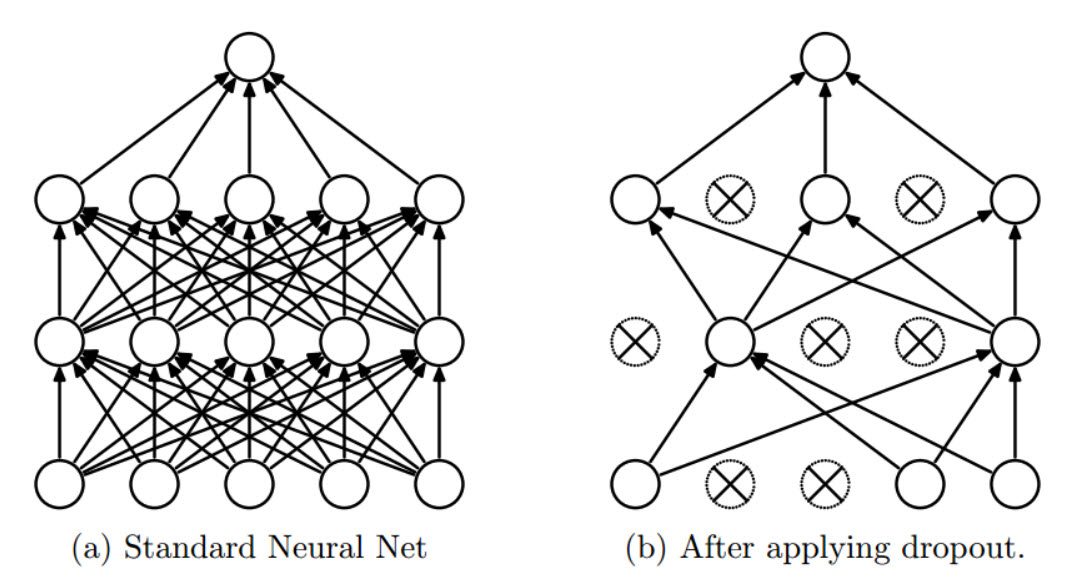

In [7]:
Image('/gdrive/My Drive/Colab Notebooks/data/News_summary/News_4.jpg')

In [ ]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 512  # 초기 512 설정

# 인코더
encoder_inputs = Input(shape=(Text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 1.7.2 디코더 설계

- decoder도 encoder와 같이 설계하지만 decoder_lstm의 initial_state를 encoder LSTM layer3의 hidden, cell의 상태(state_h, state_c)를 가져옵니다.

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### 1.7.3 Attention

- 위 decoder에서 output layer를 따로 만들지 않은 이유는 attention을 붙이기 위함입니다.

- from tensorflow.keras.layers import AdditiveAttention로 import한 Attention을 설계합니다.

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      2841600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 512),    1312768     ['embedding[0][0]']              
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

- 파라미터가 20,734,848개 입니다...

#### 1.7.4 model 훈련

- 모델을 컴파일 하고 훈련합니다.

- lyrics model에서 oprimizer를 바꿔가며 진행했었습니다.  
당시 이런 형태 시퀀스에 알맞은 optimizer 3가지를 꼽았습니다(RMSprop, Nadam, Adam)  
3개 다 넣어서 돌려본 후 가장 좋은 결과를 사용합니다.  
(colab 런타임으로 인해 하나하나 돌린 후 이미지로 저장했습니다.)

1) Adam_Optimizer

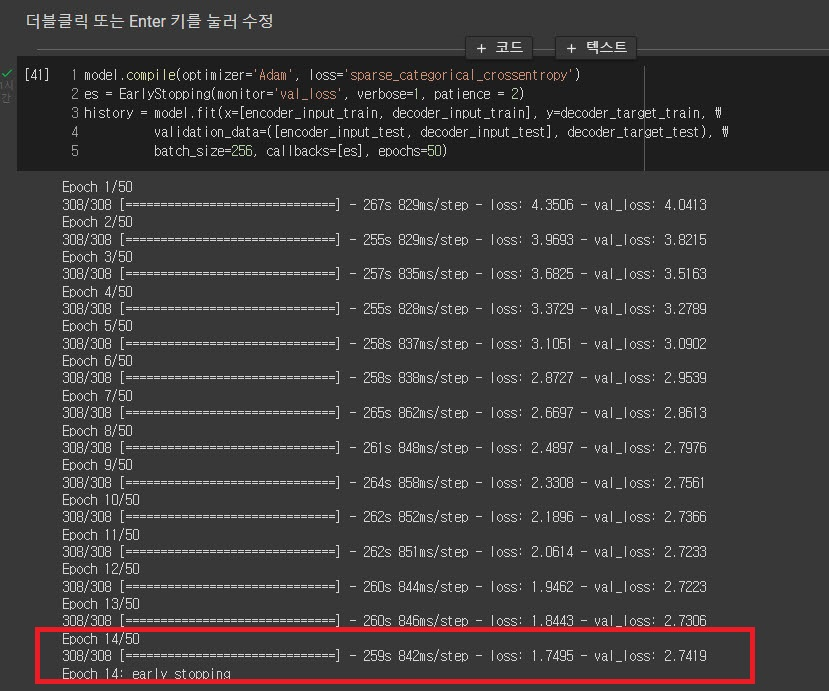

In [9]:
Image('/gdrive/My Drive/Colab Notebooks/data/News_summary/News_3.jpg')

- validation loss 값은 2.7419입니다.

2) RMSprop_Optimizer

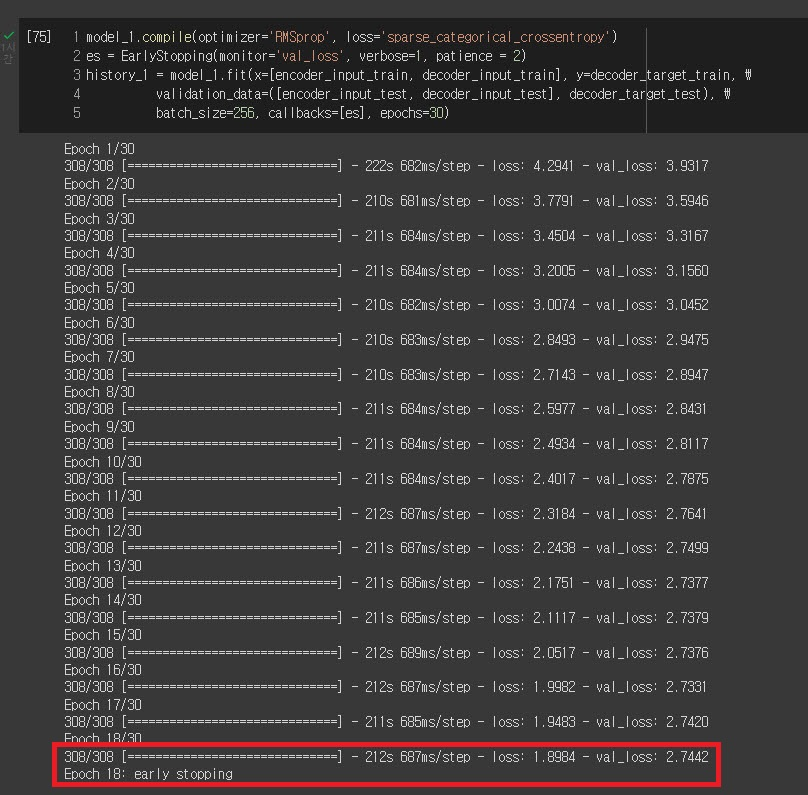

In [10]:
Image('/gdrive/My Drive/Colab Notebooks/data/News_summary/News_1.jpg')

- validation loss 값은 2.7442입니다.

3) Nadam_Optimizer

In [ ]:
model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', verbose=1, patience = 2)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 286s 884ms/step - loss: 4.2614 - val_loss: 3.9207
Epoch 2/50
308/308 [==============================] - 271s 879ms/step - loss: 3.7379 - val_loss: 3.4941
Epoch 3/50
308/308 [==============================] - 268s 870ms/step - loss: 3.3049 - val_loss: 3.1683
Epoch 4/50
308/308 [==============================] - 266s 862ms/step - loss: 2.9802 - val_loss: 2.9715
Epoch 5/50
308/308 [==============================] - 269s 873ms/step - loss: 2.7298 - val_loss: 2.8408
Epoch 6/50
308/308 [==============================] - 270s 875ms/step - loss: 2.5275 - val_loss: 2.7599
Epoch 7/50
308/308 [==============================] - 267s 868ms/step - loss: 2.3566 - val_loss: 2.7118
Epoch 8/50
308/308 [==============================] - 267s 867ms/step - loss: 2.2075 - val_loss: 2.6944
Epoch 9/50
308/308 [==============================] - 266s 864ms/step - loss: 2.0762 - val_loss: 2.6704
Epoch 10/50
308/308 [==============================] - 266s 863m

- validation loss 값은 2.6966입니다.  
큰 차이는 없어 보이지만 Nadam optimizer를 적용한 모델을 사용해 진행하겠습니다.

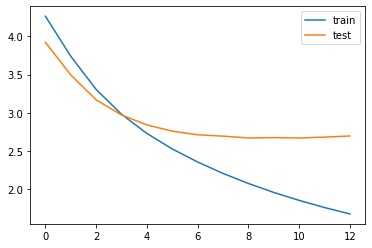

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 시각화를 통해 살펴본결과 loss값이 epoch 4를 기점으로 정체합니다.

#### 1.7.4 model 테스트

1) 사전 생성

- 사전에 만든 22200, 9600 vocabulary를 따로 저장합니다.

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

2) model 설계

- 훈련된 모델을 바탕으로 테스트를 실행하는 인퍼런스 단계에서 decoder가 만들 문장만큼 반복해야 해서 인퍼런스에 맞게 모델을 따로 설계합니다.

- encoder와 decoder를 같이 묶어 만듭니다.

- 마찬가지로 encoder의 hidden과 cell의 상태를 받아와 decoder에 넣어줍니다.

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- 마찬가지로 attention output layer를 만들어 줍니다 

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(Text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

3) model test

- test의 샘플 중 50번~100번까지만 확인해봅니다.

In [ ]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, Text_max_len)))
    print("\n")

원문 : bsp supremo mayawati alleged bjp appointed yogi adityanath kshatriya cm uttar pradesh party rss agenda said bjp gathered votes backward castes advancing keshav prasad maurya assuring cm post notably maurya appointed deputy cm 
실제 요약 : yogi made cm to further bjp rss agenda in up mayawati 
예측 요약 :  mayawati bsp to visit up in up in up


원문 : youth allegedly shot dead elderly man latter opposed visiting neighbouring girl house allahabad youth told police loved girl wanted impress allegedly killed man argument neighbours following arrested murder weapon seized 
실제 요약 : killed elderly man to girl allahabad youth 
예측 요약 :  man stabbed to death for rejecting mentally challenged in up


원문 : mumbai police registered least cases drunk driving till new year day official said actions like imposition fine driving licenses taken added till midnight december police caught total people found drunk 
실제 요약 : people caught drunk driving in mumbai on new year 
예측 요약 :  mumbai police fines clinics d

- 몇가지만 살펴보겠습니다.  
'===================================================================='  
원문 : two people arrested four detained alleged involvement violent clashes took place bulandshahr police inspector youth killed two firs filed incident including one alleged cow slaughter another violent protests followed  
실제 요약 : people arrested detained over bulandshahr clashes  
예측 요약 :  arrested for attacking policemen in bulandshahr  
경찰을 공격했다는 이야기는 없는 것 같습니다.
'===================================================================='  
원문 : two independent teams astronomers discovered three infant planets orbit around four million year old newborn star light years earth using new planet finding technique identifies unusual gas flow patterns astronomers identified three disturbances young star gas filled disk saying strongest evidence orbiting planets   
실제 요약 : three infant planets discovered around newborn star  
예측 요약 :  astronomers discover new star found around the sun  
그나마 멀쩡합니다. 별을 발견했다는 이야기는 일치합니다 newborn과 new를 구별 못하나 봅니다.
'===================================================================='  
원문 : pakistan maritime security agency captured indian fishermen seized four boats gujarat coast official national forum said fishermen sailed days ago apprehended near international maritime border line official added  
실제 요약 : pakistan captures indian fishermen off gujarat coast  
예측 요약 :  pakistan seizes fishermen held in pakistan  
그나마...  
'===================================================================='  
원문 : vodafone group ceo letter telecom minister manoj sinha said telecom industry regulated based new ambition said move reduce mobile termination charge risks destroying companies built industry also sought reduction interest rate deferred spectrum payment  
실제 요약 : rules should not suit new vodafone ceo  
예측 요약 :  idea vodafone to be ready to telcos for new telecom nilekani  
내용과는 완전히 다른 요약을 만들어냈습니다.
  
  '===================================================================='   
  원문 : reacting year old actress rhea chakraborty picture filmmaker mahesh bhatt posted th birthday trolls commented anup jalota bigg boss ka dating rhea captioned picture sir held love showed love recently year old anup jalota revealed dating year old singer jasleen matharu  
실제 요약 : rhea posts pic with mahesh bhatt trolls say he is like anup jalota  
예측 요약 :  my mother is marrying old girl on old pic with her icon  
놀라운 결과입니다... 창조의 수준입니다.  
'===================================================================='    
예측 요약 :  philippines to probe who ate the statue of the party  
어질어질합니다. 그만 봅니다...

### 1.8 summa

1) 추출적 요약

- 추출적 요약은 원문에서 중요한 핵심 문구를 바탕으로 요약문을 만드는 방법입니다.

- 이미 있는 단어를 바탕으로 요약을 하다보니 더 정확할 것 같습니다.

2) 데이터 준비

- 위에서 따로 저장했던 data_saved를 가져옵니다.  
- 어느정도 전처리가 완료된(preprocess_sentence 단계까지) 데이터입니다.

In [6]:
data_2 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/data/data_saved.csv')

3) summa test(본문)

- 정규화, 불용어처리가 된 상태를 'Text'(대문자) 컬럼에 넣었고, 'text'(소문자)는 아무 가공도 이뤄지지 않은 데이터입니다.

- 1123번을 불러와 요약해보겠습니다.  
우선 원문입니다.

In [11]:
print(data_2['text'][1123])

World Cup-winning midfielder Paul Pogba took a picture with an Australian couple as apology for disturbing them on train by making noise while playing UNO with his Manchester United teammates. The couple didn't know who Pogba was and thought he was offering to click their picture. "We kept saying, 'No...it's OK don't need one'," the couple told their son later.


- 포그바가 열차에서 소란스럽게 한 부분에 대한 사과의 의미로 호주 커플과 사진을 찍었답니다.  

- 커플은 포그바가 누군지도 모르는데 억지로 찍었나봅니다.

In [10]:
summa_test = data_2['Text'][1123]
print(summarize(summa_test, ratio=0.5))
print('complete')


complete


- 빈 값을 출력합니다.
- summa로 summarize를 시도할 때 prepocessing이 이후 상태에서는 요약을 하지 못하는 모습을 볼 수 있습니다.

In [8]:
summa_test = data_2['text'][1123]
print(summarize(summa_test, ratio=0.5))

The couple didn't know who Pogba was and thought he was offering to click their picture.


- 같은 1123번입니다. 잘 출력합니다. 헤드라인으로 딱입니다.

- 왜 포그바가 사진을 찍으려 했는지는 나오지 않았지만, 추상적 요약 모델보다는 매우 훌륭하다고 생각합니다.

4) summa test(헤드라인)

- headline 원본부터 쭉 뽑아보겠습니다.

In [16]:
print(data_2['headlines'][1123])

Pogba takes pic with couple as apology, they didn't know who he was


In [13]:
summa_test = data_2['Headlines'][1123]
print(summarize(summa_test, ratio=0.5))
print('complete')


complete


In [21]:
summa_test_2 = data_2['headlines'][1123]
print(summarize(summa_test_2, ratio=0.5))

- 짧은 헤드라인은 요약을 못하는 것 같습니다.

5) summa ratio 설정

- summa의 summarize에서는 ratio 옵션이 있습니다. 0.5면 원문의 0.5%를 출력한다는 의미인데,   
우리가 다룰 텍스트는 생각보다 짧습니다. 너무 낮으면 출력이 안될 것 같습니다.  
직접 확인해봅니다.

In [22]:
print(data_2['headlines'][15427])

India's each 100th int'l win has come under a different captain


In [34]:
print('원문 헤드라인 : ',data_2['headlines'][15427])
print('==================================================================================')
summa_test = data_2['text'][15427]
print('요약(ratio=0.1) : ',summarize(summa_test, ratio=0.1))
print('요약(ratio=0.3) : ',summarize(summa_test, ratio=0.3))
print('요약(ratio=0.6) : ',summarize(summa_test, ratio=0.6))
print('요약(ratio=0.9) : ',summarize(summa_test, ratio=0.9))
print('요약(ratio=1.2) : ',summarize(summa_test, ratio=1.2))

원문 헤드라인 :  India's each 100th int'l win has come under a different captain
요약(ratio=0.1) :  
요약(ratio=0.3) :  
요약(ratio=0.6) :  Each of the Indian cricket team's 100th international win has come under a different captain, with Rohit Sharma leading the side to its 700th international win in the Asia Cup final on Friday.
요약(ratio=0.9) :  Each of the Indian cricket team's 100th international win has come under a different captain, with Rohit Sharma leading the side to its 700th international win in the Asia Cup final on Friday.
India's maiden 100th win had come under Ravi Shastri, who is currently the coach of the Indian team.
요약(ratio=1.2) :  Each of the Indian cricket team's 100th international win has come under a different captain, with Rohit Sharma leading the side to its 700th international win in the Asia Cup final on Friday.
India's maiden 100th win had come under Ravi Shastri, who is currently the coach of the Indian team.
The list also features Sachin Tendulkar and Sourav Gangul

- 결과적으로 ratio가 너무 낮으면 요약을 전혀 못 하고 null 값을 내보냅니다.  
너무 높아도 요약을 안 하고 문단을 내보내려 합니다.  
적정 값은 0.5 ~ 0.6 정도로 보이고, 이상하면 고쳐쓰면 될 것 같습니다.

5) summa test 결과 확인

- 위에서 요약하는 과정은 확인했으니, 전체적으로 20개 정도만 살펴보고 넘어갑니다.

In [32]:
for idx, (head, text) in enumerate(zip(data_2['headlines'], data_2['text'])):
    if idx == 20:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

- 요약치고는... 본문만큼 긴 것도 있습니다만, 이정도면 추상적 요약보다는 봐줄만합니다.

# 2. 회고

1) BERT를 사용해보고 싶었습니다.
- LSTM, Attention에 대해 알아보다보니'BERT가 대세라던데'를 참 많이 봤습니다.  
그래서 BERT를 붙여서 모델을 비교해보고 싶었는데 제 지식이 아직 부족한 관계로 못해보고 넘어갑니다.  
다음에 다시 돌아와서 시도해보려합니다.

2) 불용어 처리
- NLTK의 stopwords.words에는 불용어가 179개 있습니다.
- headlines처럼 평균 단어가 10개 수준이고 3개의 단어만으로도 의미를 전달할 수 있는 짧은 문장에는 stopword 처리가 오히려 안 좋을 수 있다고 생각합니다.
- 처음 함수를 만들 때 False 값을 받아 처리를 안 하고 넘어갈 수 있게 설계하는 것이 좋겠습니다.  
clean_headlines.append(preprocess_sentence(s, False))

3) Loss 값에 대한 집착
 - Epoch 13/50  
 308/308 [==============================] - 267s 867ms/step - loss: 1.6779 - val_loss: 2.6966  
 - 생각보다 떨어지지 않는 loss에 오기가 생깁니다. 나중에 시간의 여유가 생기면 더 낮춰보고 싶습니다.

4) 하나를 배우면 배울게 열개 늘어난다.
- attention, transformer, bahdanau attention 등 배울게 쌓여갑니다...

5) Summarization은 어렵다.
- summary 과정은 어렵습니다. 특히 추상적 요약은 생각보다 더 어려운 것 같습니다.  
이번 모델의 결과를 놓고 보자면 사용이 불가할 정도입니다.  
그래서 BERT를 더 써보고 싶었습니다.

6) 공식 문서를 잘 활용하자
-  특히, TensorFlow의 공식문서는 깔끔하게 잘 정리되어 있습니다.  더 놀라운 점은 예제도 제공합니다.  
Text - Text generation에서 'seq2seq 모델을 사용한 텍스트 번역'에서 많은 내용을 확인하고 공부할 수 있었습니다.  
공식 문서를 잘 활용합시다.

# 3. References

- 아래의 사이트에서 많은 도움을 받았습니다.

- https://www.tensorflow.org/text/tutorials/nmt_with_attention#text_preprocessing  
- https://d2l.ai/chapter_recurrent-modern/encoder-decoder.html
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- https://wikidocs.net/22893
- https://wikidocs.net/21693
- https://wikidocs.net/73161
- https://hj-study.tistory.com/7
- https://wjddyd66.github.io/keras/Keras(4-2)/